# INF4480 Spring of 2021 - Project 2
### By Olav Fønstelien 2021-02-07
<br>

### Notes:
* Implementation in Python using NumPy, SciPy, matplotlib
* Generating slides from Jupyter Lab, and including most of the code since I myself think it is always interesting to see how things were done, and would also like feedback as well as tips and tricks



We begin by setting up the environment...

In [1]:
### Setting up environment
import numpy as np
from scipy.io import loadmat
from scipy.signal import correlate, resample
import matplotlib.pyplot as plt

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In this assignment we analyse the signal received by a sonar after one single ping. The sonar is an array of 32 hydrophones arranged horizontally. The ping is reflected by a fish swimming in the water some meters away, and we will look at two different ways of estimating the distance; first by the Maximum Likelihood Estimator (MLE) and then by the Linear Least Squares Estimator (LSE). We will also calculate the Cramér-Rao Lower Bound on the variance of an estimator for the received signal.

The sonar recording is stored in a file ```sonardata.mat```. Let's first read this and look at it's content:

In [33]:
sonardata = loadmat('sonardata2.mat')
print('keys =', sonardata.keys())

keys = dict_keys(['__header__', '__version__', '__globals__', 'data', 'fs', 't_0', 'T_p', 'B', 'c', 'fc'])
data shape = (8192, 32)


* ```data``` is the recorded (reflected) signal
* ```fs``` is the sampling rate
* ```t_0``` is the start of recording after (time offset)
* ```T_p``` is the pulse length
* ```B``` is the sonar signal's bandwith
* ```c``` is the sound of speed in water
* ```fc``` is the sonar signal's center frequency

Let's look a little closer on the ```data```. 

First, we see that it has 8192 samples on 32 channels, and that the signal is complex.

In [56]:
sonardata['data'].shape, sonardata['data'][:5,0]

((8192, 32),
 array([ 3.34187627 +0.91291571j, -2.22558808+10.29149246j,
        -2.85305309 +3.1848526j , -8.39871979 +1.23913801j,
        -2.8522563  -2.60386801j]))

In the assignment we will use only the first 1600, so let's look at the signal on one of the channels, say channel 12.

We see that there is something happening somewhere between 250 and 500, which corresponds to somewhere between approximately 13 and 18 meters. 

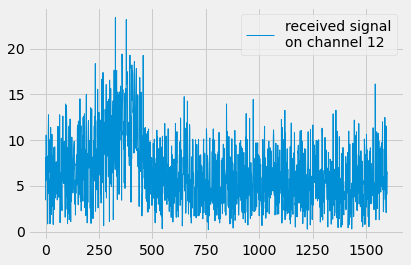

In [64]:
plt.plot(np.abs(sonardata['data'][:1600, 12]), lw=1, label='received signal\non channel 12')
plt.legend()

Let's allocate some variables for the ones that we will use in the following:

In [51]:
# Allocating variables
fs = float(sonardata['fs'])
Tp = float(sonardata['T_p'])
t0 = float(sonardata['t_0'])
B = float(sonardata['B'])
c = float(sonardata['c'])
X = sonardata['data'][:1600]
Nt, Nh = X.shape
print(f'fs={fs}, Tp={Tp}, t0={t0}, B={B}, c={c}')

fs=40000.0, Tp=0.008, t0=0.0125, B=30000.0, c=1480.0


In the following we will see if we can determine the distance with higher confidence by _matched filtering_ and the MLE and LSE methods. For that we will need to know the shape of the ping signal pulse:
$$
s(t) =  \bigg\{
    \begin{aligned}
    &\mathrm{exp}(j2 \pi \alpha t^2 / 2) \quad &&-T_p / 2 \le t \le T_p / 2\\
    &0 &&\text{otherwise}
    \end{aligned}
$$
where $\alpha = B/T_p$.

Let's plot it to see what it looks like:

In [52]:
Ns = int(Tp*fs)
alpha = B/Tp
ts = np.linspace(-Tp/2, Tp/2, Ns)
s = np.exp(1j*np.pi*alpha*ts**2)

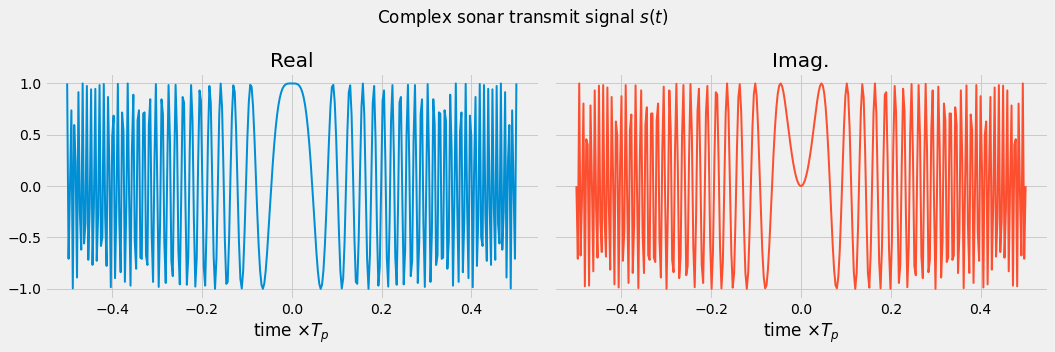

In [54]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r'Complex sonar transmit signal $s(t)$')

ax = axes[0]
ax.set_title('Real')
ax.plot(ts/tp, np.real(np.exp(1j*np.pi*alpha*ts**2)), lw=2)
ax.set_xlabel(r'time $\times T_p$')

ax = axes[1]
ax.set_title('Imag.')
ax.plot(ts/tp, np.imag(np.exp(1j*np.pi*alpha*ts**2)), lw=2, color=COLORS[1])
ax.set_xlabel(r'time $\times T_p$')

plt.tight_layout()
plt.show()

## Assignment 1 - Maximum Likelihood Estimation of Time Delay

### Ex. 1A

We begin by deriving the MLE for a signal in Gaussian white noise. The received signal $x[n], n = 0,1,2,...,N-1$ can be decomposed into the echo of the pulse $s(n - n_0)$, where $n_0$ is the discrete time-shift of the echo, and noise $w[n] \sim \mathcal{N}(0, \sigma_w^2)$. We will asume that the sampler fully covers the width of the noise, such that it can be considered _white_, and the received signal becomes:
$$
x[n] = s[n\Delta-n_0] + w[n] \quad n = 0,1,2,...,N-1
$$

Our aim now is to use the non-changing probability distribution function of the noise to derive an expression for $n_0$. Since $s$ has a finite duration $N_p = T_p f_s$, we can write the noise as
$$
w[n] =  \bigg\{
    \begin{aligned}
    &x[n] - s[n-n_0] \quad && n_0 \le n \le n_0 + N_p-1 \\
    &x[n] &&\text{otherwise}
    \end{aligned}
$$

This has the pdf
$$
p_w(w[n]; n_0) = 
                    \Bigg[ \prod_{n=1}^{n_0 - 1} C \mathrm{exp} \bigg[ - \frac{x^2[n]}{2 \sigma_w^2} \bigg] \Bigg]
                     \Bigg[ \prod_{n=n_0}^{n_0 + N_p - 1} C \mathrm{exp} \bigg[ - \frac{(x[n] - s[n-n_0])^2}{2 \sigma_w^2} \bigg] \Bigg]
                     \Bigg[ \prod_{n=n_0+N_p}^{N - 1} C \mathrm{exp} \bigg[ - \frac{x^2[n]}{2 \sigma_w^2} \bigg] \Bigg] \\
$$
The middle series exponential can be expanded to
$$
\mathrm{exp} \bigg[ - \frac{(x[n] - s[n-n_0])^2}{2 \sigma_w^2} \bigg] = 
\mathrm{exp} \bigg[ - \frac{x^2[n]}{2 \sigma_w^2} \bigg]
\mathrm{exp} \bigg[ \frac{x[n]s[n-n_0]}{\sigma_w^2} \bigg]
\mathrm{exp} \bigg[ - \frac{s^2[n-n_0]}{2 \sigma_w^2} \bigg]
$$
such that $p_w$ becomes
$$
p_w(w[n]; n_0) = 
                    C^N \Bigg[ \prod_{n=1}^{N - 1} \mathrm{exp} \bigg[ - \frac{x^2[n]}{2 \sigma_w^2} \bigg] \Bigg]
                     \Bigg[ \prod_{n=n_0}^{n_0 + N_p - 1} \mathrm{exp} \bigg[ \frac{x[n]s[n-n_0]}{\sigma_w^2} \bigg] \mathrm{exp} \bigg[ - \frac{s^2[n-n_0]}{2 \sigma_w^2} \bigg] \Bigg].
$$
We see that the first series does not depend on $n_o$, and that in the last series, we see that the second term can be made independent of $n_0$ by separating this out such that
$$
                     \prod_{n=n_0}^{n_0 + N_p - 1} \mathrm{exp} \bigg[ - \frac{s^2[n-n_0]}{2 \sigma_w^2} \bigg] = \prod_{n=0}^{N_p - 1} \mathrm{exp} \bigg[ - \frac{s^2[n]}{2 \sigma_w^2} \bigg].
$$
Now, if we let $p_w = p_w' p_w''$, where only $p_w''$ is dependent on $n_0$;
$$
p_w''(w[n]; n_0) = \prod_{n=n_0}^{n_0 + N_p - 1} \mathrm{exp} \bigg[ \frac{x[n]s[n-n_0]}{\sigma_w^2} \bigg] ,
$$
we have that
$$
\hat{n}_{0,ml} = \mathrm{argmax}_{n_0} p_w(w[n]; n_0) = \mathrm{argmax}_{n_0} p_w''(w[n]; n_0) \stackrel{\text{monotonic}}{=} \mathrm{argmax}_{n_0} \ln p_w''(w[n]; n_0).
$$
Plugging in the expression for $p_w''(w[n]; n_0)$, we get that
$$
\hat{n}_{0,ml} = \mathrm{argmax}_{n_0} \sum_{n=n_0}^{n_0 + N_p - 1} \frac{x[n]s[n-n_0]}{\sigma_w^2} = \mathrm{argmax}_{n_0} r_{xs}(n_0),
$$
where $r_{xs}(n_0)$ is the cross-correlation between $x,s$ as a function of $n_0$. Consequently, the delay is the value of $n_0$ which maximizes the cross-correlation between the ping $s$ and the received signal $x$.

### Ex. 1B

The Python module SciPy implements a method ```correlate()``` which calculates the cross-correlation between two sequences. We will wrap this in a method ```matched_filtering()``` which lets us send in the full set of sampled data and performs cross correlation with the pulse sequence. Then, all we need to do is to pick out the largest (absolute) value in each column of the returned 2D array, as we do in ```peak_indexes()```.

In [6]:
def matched_filtering(X, s):
    '''Performs matched filtering of X by s. X is the received signal of an array ordered by (channel, signal).'''
    xc = np.empty(X.shape, dtype=np.complex)
    for i, x in enumerate(X.T):
        xc[:,i] = correlate(x, s, mode='same')
    return xc

def peak_indexes(X, start=None, end=None):
    '''Returns array with peaks along X's second axis in the range (start:end)'''
    peak_idx = np.argmax(np.abs(X[start:end]), axis=0)
    return peak_idx

### Ex. 1C

Let's look at the output from ```matched_filtering()``` for channel 12 and compare this to the raw signal.

We see that the filtered signal contains one very evident peak, which is surrounded by noise. The cross-correlation can be viewed as a dot product between the pulse and the received signal. This performs a similarity-filtering on the received signal, which explains the strong amplification of the echo.

In [107]:
x12 = np.abs(X[:,12])
Xc = matched_filtering(X, s)
xc12 = np.abs(Xc[:,12])

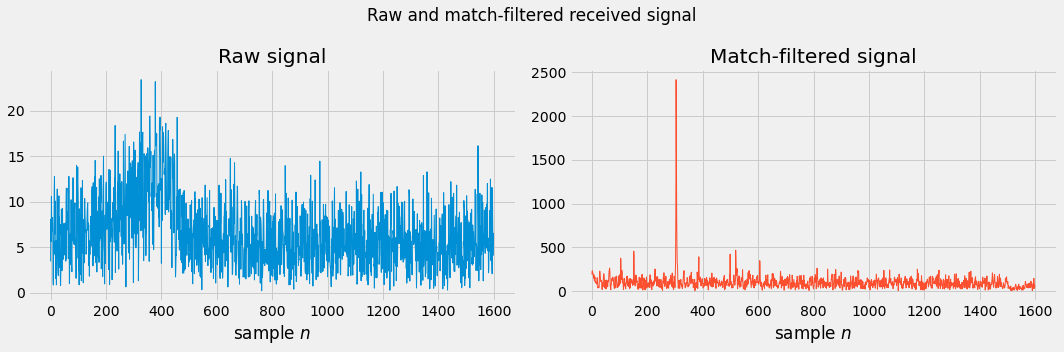

In [108]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=False, figsize=(15,5))
fig.suptitle(r'Raw and match-filtered received signal')

ax = axes[0]
ax.set_title('Raw signal')
ax.plot(x12, lw=1)
ax.set_xlabel(r'sample $n$')

ax = axes[1]
ax.set_title('Match-filtered signal')
ax.plot(xc12, lw=1, color=COLORS[1])
ax.set_xlabel(r'sample $n$')

plt.tight_layout()
plt.show()

### Ex. 1D

A closer look at the peak in the filtered signal shows that we can upsample the signal to better determine the exact location of the peak:

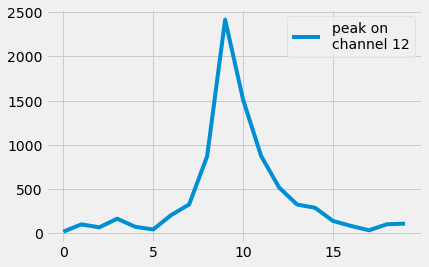

In [109]:
plt.plot(xc12[295:315], label='peak on\nchannel 12')
plt.legend()

Let's implement a method to handle the upsampling and then perform the filtering:

In [110]:
def matched_filtering_up(X, s, up=1):
    '''Matched filtering of X by s with upsampling.'''
    X_up = X
    s_up = s
    if up > 1:
        Nt, Nh = X.shape
        X_up = np.empty((up*Nt, Nh), dtype=np.complex)
        for i, x in enumerate(X.T):
            X_up[:,i] = resample(x, up*Nt)
        s_up = resample(s, up*len(s))
    
    xc = matched_filtering(X_up, s_up)
    return xc

Now, upsampling by a factor of 4 and 8 gives us a smoother line to work with, as well as higher resolution on the $x$-axis. This will let us estimate the time delay with higher precision. We note that upsampling beyond 4 gives very little benefit in terms of smoothing the line, but higher resolution on the $x$-axis may still be beneficial.

In [113]:
# Calculating cross-correlation with upsampling by 4 and 8
Xc1 = matched_filtering_up(X, s, up=1)/(1*Nt)
xc1 = np.abs(Xc1[:,12])
t1 = np.linspace(0, Nt/fs, Nt)

Xc4 = matched_filtering_up(X, s, up=4)/(4*Nt)
xc4 = np.abs(Xc4[:,12])
t4 = np.linspace(0, Nt/fs, Nt*4)

Xc8 = matched_filtering_up(X, s, up=8)/(8*Nt)
xc8 = np.abs(Xc8[:,12])
t8 = np.linspace(0, Nt/fs, Nt*8)

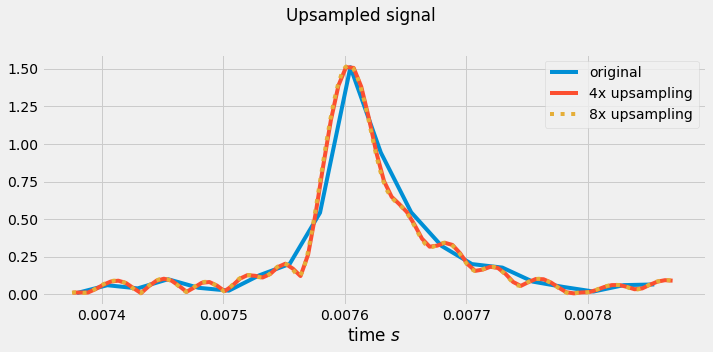

In [114]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=False, figsize=(10,5))
fig.suptitle(r'Upsampled signal')

ax = axes
ax.plot(t1[295*1:315*1], xc1[295*1:315*1], label='original')
ax.plot(t4[295*4:315*4], xc4[295*4:315*4], label='4x upsampling')
ax.plot(t8[295*8:315*8], xc8[295*8:315*8], ls=':', label='8x upsampling')
ax.set_xlabel(r'time $s$')
ax.legend()

plt.tight_layout()
plt.show()

Now, lets see how the time translates into distance from the sonar to the object which has reflected the ping. The distance to the object which reflects the echo is given by
$$
r = \frac{c}{2} t_{tot}  = \frac{c}{2} \bigg(t_0 + \frac{\hat{n}_{0,ml}}{kf_s} \bigg),
$$
where $c$ is the speed of sound in water, $t_0$ is the time offset, and $\hat{n}_{0,ml}$ is the ML estimator. $f_s$ is the samping frequency and $k$ is the upsampling factor. This gives us

In [115]:
# Calculating  for all channels and with upsampling 4 and 8
n1 = peak_indexes(Xc1)
r1 = (t0 + n1/(fs*1))*c/2

n4 = peak_indexes(Xc4)
r4 = (t0 + n4/(fs*4))*c/2

n8 = peak_indexes(Xc8)
r8 = (t0 + n8/(fs*8))*c/2

...which we plot...

We see that the upsampling makes the curve smoother, and that increasing from 4 to 8 has a certain benefit, all though quite limited -- we will be able to estimate the distance with centimeter-precision even without applying upsampling.

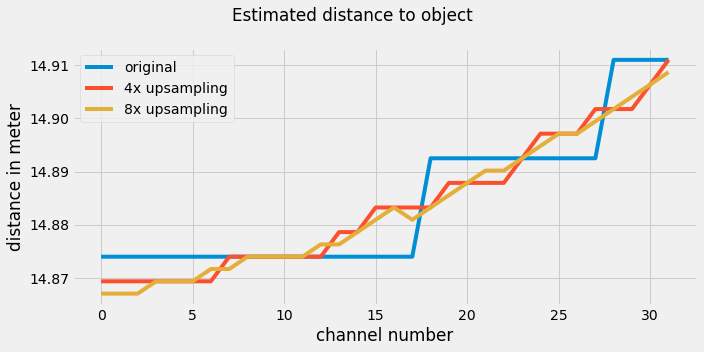

In [120]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=False, figsize=(10,5))
fig.suptitle(r'Estimated distance to object')

ax = axes
ax.plot(r1, label='original')
ax.plot(r4, label='4x upsampling')
ax.plot(r8, label='8x upsampling')
ax.set_xlabel(r'channel number')
ax.set_ylabel(r'distance in meter')
ax.legend()

plt.tight_layout()
plt.show()

## Assignment 3 - Least Squares Estimation of Time Delay

### Ex. 3A

We will now investigate how LSE performs on the same task as done for MLE in Assignment 1.

From the plots of the match-filtered pulse in Assignment 1, we see that the echo resembles a Gaussian distribution. When we apply the MLE method we model the received signal as a Gaussian distribution in noise, and let the noise represent the _error_ in the MLE loss function, $\varepsilon(t) = x(t) - s(t;\mathbb{\theta}) $. For $x(t)$ we will use the match-filtered signal, such that $x(t) \rightarrow r_{xs}[n_0]$ and for $s_{\theta}[n]$, we will use the Gaussian distribution;
$$
s(t;\mathbb{\theta}) = I_0 \mathrm{exp} \bigg[ - \frac{(t - \tau_0)^2}{2 \sigma_B^2} \bigg]
$$
Taking the logarithm of both sides gives us a linear equation with three unknowns $\mathbb{\theta} = [\theta_0 \quad \theta_1 \quad \theta_2]^T$.
$$
\ln s(t;\mathbb{\theta}) = \bigg(\ln I_0 - \frac{\tau_0^2}{2 \sigma_B^2} \bigg) + \bigg( \frac{\tau_0}{\sigma_B^2} \bigg)t + \bigg( -\frac{1}{2 \sigma_B^2} \bigg)t^2 
                         = [1 \quad t \quad t^2] \cdot [\theta_0 \quad \theta_1 \quad \theta_2]
$$

The LS estimator is then found 

We follow the algorithm suggested in the lecture notes 

In [19]:
def pulse_mask(X):
    X = np.abs(X)**2
    peaks = np.amax(X, axis=0)
    mask = X > .5*peaks
    return mask

def lse(X, t):
    _, Nh = X.shape
    T = np.empty((3, Nh))    
    for i, x in enumerate(X.T):
        nonzero_idx = np.nonzero(x)
        x_nz = x[nonzero_idx]
        t_nz = t[nonzero_idx].reshape(-1,1)
        H = np.hstack((np.ones((len(t_nz),1)), t_nz, t_nz**2))
        T[:,i] = np.linalg.inv(H.T @ H) @ H.T @ x_nz
    
    sigma2 = -1/(2*T[2])
    tau0 = -T[1]/(2*T[2])
    I0 = np.exp(T[0] - T[1]**2/(4*T[2]))
    return (sigma2, tau0, I0)

In [29]:
up = 4
xc = np.abs(xcorr(X, s, up=up)/(up*Nt))
mask = pulse_mask(xc)
xlog = np.log(xc)*mask
t = np.linspace(0, Nt/fs, up*Nt)
res = lse(xlog, t)

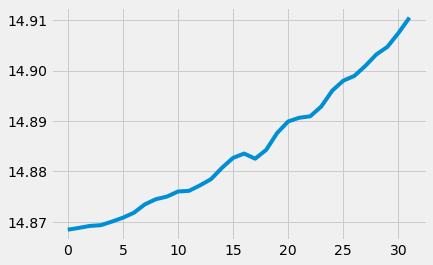

In [30]:
sigma2, tau, I0 = res
r_ml = (t0 + tau)*c/2
plt.plot(r_ml)

In [31]:
sigma20, tau0, I00 = sigma2[0], tau[0], I0[0]

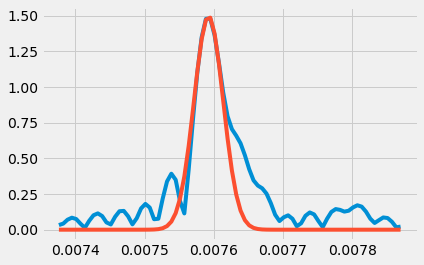

In [32]:
start, end = 295*up, 315*up
time = t[start:end]
plt.plot(time, xc[start:end, 0])
plt.plot(time, I00*np.exp(-(time-tau0)**2 / (2*sigma20)))